In [1]:
import sbi
from sbi.inference import SNLE, likelihood_estimator_based_potential

import torch
torch.manual_seed(0)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("../../.matplotlibrc")

In [2]:
!pip install sbibm --no-deps

In [3]:
from sbibm.tasks import get_task

In [4]:
task = get_task("two_moons")

In [5]:
prior = task.get_prior_dist()
simulator = task.get_simulator()

In [6]:
thetas = prior.sample((10000,))
xs = simulator(thetas)

In [7]:
inference = SNLE(prior)

In [8]:
density_estimator = inference.append_simulations(thetas, xs).train()

 Neural network successfully converged after 124 epochs.

In [9]:
x_o = task.get_observation(1)

In [10]:
torch.manual_seed(42)
posterior = inference.build_posterior(sample_with="mcmc", mcmc_parameters={"thin":1})

In [11]:
posterior2 = inference.build_posterior(sample_with="mcmc", mcmc_parameters={"num_chains": 10, "num_workers": 10, "thin":1})

In [12]:
true_posterior = task.get_reference_posterior_samples(1)

In [13]:
from sbi.inference import VIPosterior

In [14]:
from torch.distributions import Independent, Normal, MixtureSameFamily, Categorical
mean = torch.tensor([[-1, -1],[1.,1.]], requires_grad=True)
scale = torch.tensor([[0.4,0.4],[0.4, 0.4]], requires_grad=True)
q = Independent(Normal(mean, torch.relu(scale) + 0.01), 1)
q = MixtureSameFamily(Categorical(probs=torch.tensor([0.5, 0.5])), q)
q.has_rsample = True
params = [mean, scale]

In [15]:
torch.manual_seed(1)
potential_fn, _ = likelihood_estimator_based_potential(density_estimator, prior, x_o)

In [16]:
posterior3 = VIPosterior(potential_fn, prior, q,vi_method="fKL", parameters=params)

In [17]:
torch.manual_seed(2)
posterior4 =  VIPosterior(potential_fn, prior, q="nsf",vi_method="rKL")

In [18]:
torch.manual_seed(42)
samples = posterior.sample((10000,), x=x_o)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10010 [00:00<?, ?it/s]

In [19]:
samples2 = posterior2.sample((10000,), x=x_o)

Generating 10 MCMC inits with 10
                         workers.:   0%|          | 0/10 [00:00<?, ?it/s]

Running 10 MCMC chains with
                      10 workers.:   0%|          | 0/10 [00:00<?, ?it/s]

In [20]:
torch.manual_seed(1)
posterior3.set_default_x(x_o)
posterior3.train(warm_up_rounds=0, max_num_iters=2000,n_particles=1024, check_for_convergence=False)

  0%|          | 0/2000 [00:00<?, ?it/s]

Quality Score: -1.05 	 Good: Smaller than 0.5  Bad: Larger than 1.0 	         NOTE: Less sensitive to mode collapse.


VIPosterior sampler for potential_fn=<LikelihoodBasedPotential>

In [21]:
samples3 = posterior3.sample((100000,), x=x_o)

In [22]:
torch.manual_seed(2)
posterior4.set_default_x(x_o)
posterior4.train(eps=0.00001)

  0%|          | 0/2000 [00:00<?, ?it/s]


Converged with loss: 1.57
Quality Score: -0.055 	 Good: Smaller than 0.5  Bad: Larger than 1.0 	         NOTE: Less sensitive to mode collapse.


VIPosterior sampler for potential_fn=<LikelihoodBasedPotential>

In [23]:
samples4 = posterior4.sample((100000,), x=x_o)

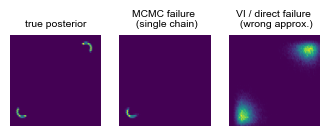

In [26]:
fig, ax = plt.subplots(1,3, figsize=(4,1.5))

x_lim = (-1, 0.8)
y_lim = (-0.8, 1)

ax[0].hexbin(true_posterior[:,0], true_posterior[:,1], gridsize=100, cmap="viridis", extent = x_lim + y_lim, rasterized=True)
ax[1].hexbin(samples[:,0], samples[:,1], gridsize=100, cmap="viridis", extent = x_lim + y_lim, rasterized=True)
ax[2].hexbin(samples3[:,0], samples3[:,1], gridsize=100, cmap="viridis", extent = x_lim + y_lim, rasterized=True)
#ax[2].hexbin(samples4[:,0], samples4[:,1], gridsize=100, cmap="viridis", extent = x_lim + y_lim, rasterized=True)

ax[0].set_title("true posterior")
ax[1].set_title("MCMC failure \n (single chain)")
#ax[2].set_title("VI failure \n (mode seeking rKL)")
ax[2].set_title("VI / direct failure \n (wrong approx.)")

for ax in ax:
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")
    ax.axis("off")

fig.savefig("figs/two_moons_failure.svg", bbox_inches = 'tight', pad_inches = 0)
fig.savefig("figs/two_moons_failure.png", bbox_inches = 'tight', pad_inches = 0)

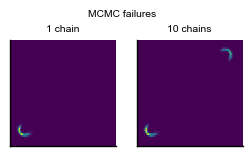

In [27]:
fig, axes  = plt.subplots(1, 2, figsize=(3, 1.38))

x_lim = (-1, 0.8)
y_lim = (-0.8, 1)

fig.suptitle("MCMC failures", y=1.1)

axes[0].hexbin(samples[:, 0], samples[:, 1], extent=x_lim + y_lim, gridsize=100)
axes[0].set_xlim(*x_lim)
axes[0].set_ylim(*y_lim)
axes[0].set_title("1 chain")
axes[0].set_xticks([])
axes[0].set_yticks([])


axes[1].hexbin(samples2[:, 0], samples2[:, 1], extent=x_lim + y_lim, gridsize=100)
axes[1].set_xlim(*x_lim)
axes[1].set_ylim(*y_lim)
axes[1].set_title("10 chains")
axes[1].set_xticks([])
axes[1].set_yticks([])

# axes[0,1].hexbin(samples3[:, 0], samples3[:, 1], extent=x_lim + y_lim, gridsize=100)
# axes[0,1].set_xlim(*x_lim)
# axes[0,1].set_ylim(*y_lim)
# axes[0,1].set_xticks([])
# axes[0,1].set_yticks([])
# axes[0,1].set_title("mode seeking VI")


# axes[1,1].hexbin(samples4[:, 0], samples4[:, 1], extent=x_lim + y_lim, gridsize=100)
# axes[1,1].set_xlim(*x_lim)
# axes[1,1].set_ylim(*y_lim)
# axes[1,1].set_xticks([])
# axes[1,1].set_yticks([])
# axes[1,1].set_title("mass covering VI")

# fig.suptitle("MCMC failues                               VI failures")
fig.savefig("./figs/mcmc_mode_failure.svg", bbox_inches="tight")
fig.savefig("./figs/mcmc_mode_failure.png", bbox_inches="tight")